In [1]:
#  Logo in enhancers

In [1]:
# parameters

CELLS = ['GM12878', 'HepG2', 'K562', 'A549', 'H1']

origin_cell = 'GM12878'

TF = 'ETS1'
binding_site = 'GCCGGAAG'
methyl_class = 'CpG'
methyl_pos = 3 #Start from 1!!!!!!


In [2]:
import pandas as pd

# Read enhancers for all cells
df_enhancers = {}
for cell in CELLS:
    enh = pd.read_csv(f'data/{cell}_enhancers_hg38.bed', sep='\t', header=None)
    enh = enh.rename(columns={0: 'chrom', 1: 'start', 2: 'end', 3: 'score'})

    # Drop rows where chr has underscore
    enh = enh[~enh['chrom'].str.contains('_')]

    df_enhancers[cell] = enh

In [3]:
df_enhancer = df_enhancers[origin_cell]

In [4]:
other_cells = [cell for cell in CELLS if cell != origin_cell]

In [5]:
# Read enhancers for all cells
df_mehyl_plus = {}
df_mehyl_minus = {}
for cell in CELLS:

    mehyl_plus = f'data/{cell}_wgbs_cpg_plus.bigWig'
    mehyl_minus = f'data/{cell}_wgbs_cpg_minus.bigWig'

    df_mehyl_plus[cell] = mehyl_plus
    df_mehyl_minus[cell] = mehyl_minus


In [6]:
# This is GRH38, get the sequence

hg38_path = '/home/solozabal/Documents/github/build-deepsea-training-dataset/data_hg38/hg38.fa'

In [7]:
from pyfaidx import Fasta

# Get the sequence
hg38 = Fasta(hg38_path)

def get_sequence(row):
    chrom = row[0]
    start = row[1]
    end = row[2]

    sequence = str(hg38[chrom][start:end])
    sequence = sequence.upper()

    return sequence

df_enhancer['sequence'] = df_enhancer.apply(get_sequence, axis=1)

/tmp/ipykernel_2435782/3736724702.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chrom = row[0]
/tmp/ipykernel_2435782/3736724702.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start = row[1]
/tmp/ipykernel_2435782/3736724702.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = row[2]


<Axes: >

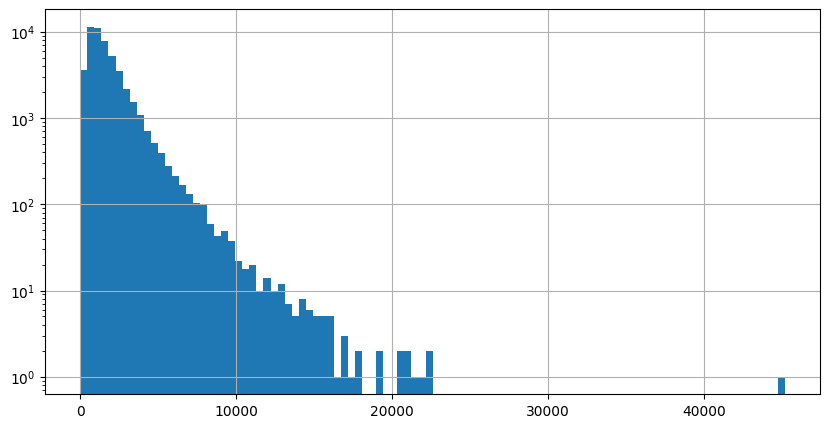

In [8]:
# histgram of length

df_enhancer['length'] = df_enhancer['end'] - df_enhancer['start']

# log scale
df_enhancer['length'].hist(bins=100, figsize=(10, 5), log=True)

In [9]:
df_enhancer

,chrom,start,end,score,sequence,length
0,chr1,837920,838720,7.866088,AGCCTGTGCTTGTCCTCAGAGGGTGGGAGCCCCATCCCAGGTGTGG...,800
1,chr1,843600,844070,6.472419,CCTACTCACTCGAATCACTAGAGAATACCAAATAGGAATAGGAAGA...,470
2,chr1,864720,866620,11.010675,CCTAACTAGGCCAGTTTTTGGACTGTATGCCAGCCTCTTTCTGCGG...,1900
3,chr1,890290,891030,6.114487,TTGGGATTACAGGCGTGAGCCACTGCACCCGGCCTTGACTTCTCAA...,740
4,chr1,904090,907210,8.848865,CCTGCTGCACTCAGAGTGGAGGATGGGAGGCCTGGGGCGGAGGGCC...,3120
...,...,...,...,...,...,...
50496,chrX,155216573,155217383,9.207927,TGGTAAGAGGCACGCTGTTCCCTGGCATCTTGGCTTGAGGCCTTGG...,810
50497,chrX,155229448,155230378,5.836427,TCTTTTATTATCTTTTGGGAATAATAAATATGCATATGTTCGATCT...,930
50498,chrX,155230838,155231708,8.231231,ATGCCCAGCTAAATTTTTTGGTAGAGACGGGGTTTTGCCATTTTGG...,870
50499,chrX,155611949,155612789,7.930245,AAGTGTTTCTTAAATATGAGAGCTCAAGTTTTTCTTTCAGCGACTG...,840


In [10]:
# If enhancer > 100000 remove

df_enhancer = df_enhancer[df_enhancer['length'] < 100000]

In [11]:
# What are the CpG methylation levels
 
import pyBigWig
from tqdm import tqdm
import re

def get_methylation_level(row, bw_plus, bw_minus):
    chrom = row[0]
    start = row[1]
    end = row[2]
    
    # Get the methylation level over the region
    methylation_plus = bw_plus.values(chrom, start, end)
    methylation_minus = bw_minus.values(chrom, start, end)
    
    return methylation_plus, methylation_minus


import numpy as np

def classify_cpgs(row, cell):

    methyl_matches_c = []
    methyl_matches_g = []

    for match in re.finditer(binding_site, row['sequence']):

        pos_c = match.start() + methyl_pos -1  # Position of C in the CpG dinucleotide in the motif
        pos_g = match.start() + methyl_pos   # Position of G in the CpG dinucleotide in the motif
        # Check that the indices are within bounds of the methylation arrays
        if pos_c >= len(row[f'methyl_plus_{cell}']) or pos_g >= len(row[f'methyl_minus_{cell}']):
            continue

        val_c = row[f'methyl_plus_{cell}'][pos_c]
        val_g = row[f'methyl_minus_{cell}'][pos_g]

        methyl_matches_c.append(val_c)
        methyl_matches_g.append(val_g)


    return methyl_matches_c, methyl_matches_g

# Count matches with binding site
df_enhancer['num_matches'] = df_enhancer['sequence'].apply(lambda x: len(re.findall(binding_site, x)))


from tqdm.notebook import tqdm
# Apply the function to get methylation levels
for cell in tqdm(CELLS):

    bw_plus = pyBigWig.open(df_mehyl_plus[cell])
    bw_minus = pyBigWig.open(df_mehyl_minus[cell])

    methylation_levels = df_enhancer.apply( lambda row: get_methylation_level(row, bw_plus, bw_minus), axis=1)

    # Assign the values to the dataframe
    df_enhancer[f'methyl_plus_{cell}'] = methylation_levels.apply(lambda x: x[0])
    df_enhancer[f'methyl_minus_{cell}'] = methylation_levels.apply(lambda x: x[1])

    # pybigwig close
    bw_plus.close()
    bw_minus.close()

    # Classify
    methyl_matches = df_enhancer.apply(lambda row: classify_cpgs(row, cell), axis=1)
    methyl_matches_c, methyl_matches_g = zip(*methyl_matches)
    df_enhancer[f'methylation_match_C_{cell}'] = methyl_matches_c
    df_enhancer[f'methylation_match_G_{cell}'] = methyl_matches_g


    # Remove 
    df_enhancer = df_enhancer.drop(columns=[f'methyl_plus_{cell}', f'methyl_minus_{cell}'])



  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_2435782/394669282.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chrom = row[0]
/tmp/ipykernel_2435782/394669282.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start = row[1]
/tmp/ipykernel_2435782/394669282.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = row[2]
/tmp/ipykernel_2435782/394669282.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

In [12]:
df_enhancer

,chrom,start,end,score,sequence,length,num_matches,methylation_match_C_GM12878,methylation_match_G_GM12878,methylation_match_C_HepG2,methylation_match_G_HepG2,methylation_match_C_K562,methylation_match_G_K562,methylation_match_C_A549,methylation_match_G_A549,methylation_match_C_H1,methylation_match_G_H1
0,chr1,837920,838720,7.866088,AGCCTGTGCTTGTCCTCAGAGGGTGGGAGCCCCATCCCAGGTGTGG...,800,0,[],[],[],[],[],[],[],[],[],[]
1,chr1,843600,844070,6.472419,CCTACTCACTCGAATCACTAGAGAATACCAAATAGGAATAGGAAGA...,470,0,[],[],[],[],[],[],[],[],[],[]
2,chr1,864720,866620,11.010675,CCTAACTAGGCCAGTTTTTGGACTGTATGCCAGCCTCTTTCTGCGG...,1900,0,[],[],[],[],[],[],[],[],[],[]
3,chr1,890290,891030,6.114487,TTGGGATTACAGGCGTGAGCCACTGCACCCGGCCTTGACTTCTCAA...,740,0,[],[],[],[],[],[],[],[],[],[]
4,chr1,904090,907210,8.848865,CCTGCTGCACTCAGAGTGGAGGATGGGAGGCCTGGGGCGGAGGGCC...,3120,0,[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50496,chrX,155216573,155217383,9.207927,TGGTAAGAGGCACGCTGTTCCCTGGCATCTTGGCTTGAGGCCTTGG...,810,0,[],[],[],[],[],[],[],[],[],[]
50497,chrX,155229448,155230378,5.836427,TCTTTTATTATCTTTTGGGAATAATAAATATGCATATGTTCGATCT...,930,0,[],[],[],[],[],[],[],[],[],[]
50498,chrX,155230838,155231708,8.231231,ATGCCCAGCTAAATTTTTTGGTAGAGACGGGGTTTTGCCATTTTGG...,870,0,[],[],[],[],[],[],[],[],[],[]
50499,chrX,155611949,155612789,7.930245,AAGTGTTTCTTAAATATGAGAGCTCAAGTTTTTCTTTCAGCGACTG...,840,0,[],[],[],[],[],[],[],[],[],[]


In [96]:
# Intersecting with other cells

In [13]:
import numpy as np
from tqdm import tqdm


def intersection_cells(df_1, df_2):
    overlap_pairs = []

    # Find common chromosomes
    common_chroms = set(df_1['chrom']).intersection(set(df_2['chrom']))

    for chrom in tqdm(common_chroms):
        # Select intervals for the current chromosome
        intervals_1 = df_1[df_1['chrom'] == chrom]
        intervals_2 = df_2[df_2['chrom'] == chrom].sort_values('start')
        
        for _, row_1 in intervals_1.iterrows():
            start_1, end_1 = row_1['start'], row_1['end']
            length_1 = end_1 - start_1

            # Vectorized candidate selection for HepG2 intervals that might overlap
            candidates = intervals_2[(intervals_2['end'] > start_1) & (intervals_2['start'] < end_1)]
            if candidates.empty:
                continue
            
            # Convert candidate columns to NumPy arrays for fast arithmetic
            starts_2 = candidates['start'].values
            ends_2 = candidates['end'].values
            lengths_2 = ends_2 - starts_2
            
            # Compute the overlapping region vectorized
            overlap = np.minimum(end_1, ends_2) - np.maximum(start_1, starts_2)
            
            # Determine valid overlaps with at least 50% reciprocal overlap
            valid = (overlap > 0) & ((overlap / length_1 >= 0.5) & (overlap / lengths_2 >= 0.5))
            if not np.any(valid):
                continue
            
            # Add each valid overlap to the result list
            for start_2, end_2, ov in zip(starts_2[valid], ends_2[valid], overlap[valid]):
                overlap_pairs.append({
                    'chrom': chrom,
                    'start_1': start_1,
                    'end_1': end_1,
                    'start_2': start_2,
                    'end_2': end_2,
                    'overlap': ov
                })

    return pd.DataFrame(overlap_pairs)



In [14]:
for other_cell in other_cells:
    df_enhancer[f'enhancer_{other_cell}'] = False
    df_enhancer[f'overlap_enhancer_{other_cell}'] = np.nan
    
    intersections = intersection_cells(df_enhancers[origin_cell], df_enhancers[other_cell])

    for _, row in intersections.iterrows():
        chrom = row['chrom']
        start = row['start_1']
        end = row['end_1']

        df_enhancer.loc[(df_enhancer['chrom'] == chrom) & (df_enhancer['start'] == start) & (df_enhancer['end'] == end), f'enhancer_{other_cell}'] = True

        df_enhancer.loc[(df_enhancer['chrom'] == chrom) & (df_enhancer['start'] == start) & (df_enhancer['end'] == end), f'overlap_enhancer_{other_cell}'] = row['overlap']



100%|██████████| 23/23 [00:14<00:00,  1.56it/s]


In [15]:
df_enhancer

,chrom,start,end,score,sequence,length,num_matches,methylation_match_C_GM12878,methylation_match_G_GM12878,methylation_match_C_HepG2,...,methylation_match_C_H1,methylation_match_G_H1,enhancer_HepG2,overlap_enhancer_HepG2,enhancer_K562,overlap_enhancer_K562,enhancer_A549,overlap_enhancer_A549,enhancer_H1,overlap_enhancer_H1
0,chr1,837920,838720,7.866088,AGCCTGTGCTTGTCCTCAGAGGGTGGGAGCCCCATCCCAGGTGTGG...,800,0,[],[],[],...,[],[],False,NaN,False,NaN,False,NaN,False,NaN
1,chr1,843600,844070,6.472419,CCTACTCACTCGAATCACTAGAGAATACCAAATAGGAATAGGAAGA...,470,0,[],[],[],...,[],[],False,NaN,False,NaN,True,440.0,True,370.0
2,chr1,864720,866620,11.010675,CCTAACTAGGCCAGTTTTTGGACTGTATGCCAGCCTCTTTCTGCGG...,1900,0,[],[],[],...,[],[],False,NaN,False,NaN,False,NaN,False,NaN
3,chr1,890290,891030,6.114487,TTGGGATTACAGGCGTGAGCCACTGCACCCGGCCTTGACTTCTCAA...,740,0,[],[],[],...,[],[],False,NaN,False,NaN,False,NaN,False,NaN
4,chr1,904090,907210,8.848865,CCTGCTGCACTCAGAGTGGAGGATGGGAGGCCTGGGGCGGAGGGCC...,3120,0,[],[],[],...,[],[],False,NaN,True,3120.0,False,NaN,True,3120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50496,chrX,155216573,155217383,9.207927,TGGTAAGAGGCACGCTGTTCCCTGGCATCTTGGCTTGAGGCCTTGG...,810,0,[],[],[],...,[],[],True,740.0,True,780.0,True,810.0,True,810.0
50497,chrX,155229448,155230378,5.836427,TCTTTTATTATCTTTTGGGAATAATAAATATGCATATGTTCGATCT...,930,0,[],[],[],...,[],[],False,NaN,False,NaN,False,NaN,True,930.0
50498,chrX,155230838,155231708,8.231231,ATGCCCAGCTAAATTTTTTGGTAGAGACGGGGTTTTGCCATTTTGG...,870,0,[],[],[],...,[],[],False,NaN,False,NaN,False,NaN,False,NaN
50499,chrX,155611949,155612789,7.930245,AAGTGTTTCTTAAATATGAGAGCTCAAGTTTTTCTTTCAGCGACTG...,840,0,[],[],[],...,[],[],False,NaN,True,840.0,True,840.0,True,650.0


In [16]:
# Check DNAse in target cell
from intervaltree import Interval, IntervalTree

for other_cell in CELLS:

    df_target_dnase = pd.read_csv(f'data/{other_cell}_dnase.bed', sep='\t', header=None)
    

    # Create a dictionary to store an interval tree for each chromosome
    dnase_trees = {}

    # Assuming df_target_dnase has columns 'chromosome', 'start', and 'end'
    for idx, row in df_target_dnase.iterrows():
        chrom = row[0]
        start = row[1]
        end = row[2]
        if chrom not in dnase_trees:
            dnase_trees[chrom] = IntervalTree()
        dnase_trees[chrom].add(Interval(start, end))

    # Function to find overlapping DNase regions for a given chromosome
    def find_dnase_overlaps(chrom, start, end):
        if chrom in dnase_trees:
            return dnase_trees[chrom][start:end]
        else:
            return []  # No data available for the chromosome

    # Assuming df_enhancer has columns 'chromosome', 'start', and 'end'
    df_enhancer[f'dnase_{other_cell}'] = df_enhancer.apply(lambda row: find_dnase_overlaps(row['chrom'], row['start'], row['end']), axis=1)

    # True of False if there is an overlap
    df_enhancer[f'dnase_{other_cell}'] = df_enhancer[f'dnase_{other_cell}'].apply(lambda x: len(x) > 0)

In [17]:
df_enhancer

,chrom,start,end,score,sequence,length,num_matches,methylation_match_C_GM12878,methylation_match_G_GM12878,methylation_match_C_HepG2,...,overlap_enhancer_K562,enhancer_A549,overlap_enhancer_A549,enhancer_H1,overlap_enhancer_H1,dnase_GM12878,dnase_HepG2,dnase_K562,dnase_A549,dnase_H1
0,chr1,837920,838720,7.866088,AGCCTGTGCTTGTCCTCAGAGGGTGGGAGCCCCATCCCAGGTGTGG...,800,0,[],[],[],...,NaN,False,NaN,False,NaN,False,False,False,False,False
1,chr1,843600,844070,6.472419,CCTACTCACTCGAATCACTAGAGAATACCAAATAGGAATAGGAAGA...,470,0,[],[],[],...,NaN,True,440.0,True,370.0,False,False,False,False,False
2,chr1,864720,866620,11.010675,CCTAACTAGGCCAGTTTTTGGACTGTATGCCAGCCTCTTTCTGCGG...,1900,0,[],[],[],...,NaN,False,NaN,False,NaN,True,False,False,False,False
3,chr1,890290,891030,6.114487,TTGGGATTACAGGCGTGAGCCACTGCACCCGGCCTTGACTTCTCAA...,740,0,[],[],[],...,NaN,False,NaN,False,NaN,False,False,False,False,False
4,chr1,904090,907210,8.848865,CCTGCTGCACTCAGAGTGGAGGATGGGAGGCCTGGGGCGGAGGGCC...,3120,0,[],[],[],...,3120.0,False,NaN,True,3120.0,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50496,chrX,155216573,155217383,9.207927,TGGTAAGAGGCACGCTGTTCCCTGGCATCTTGGCTTGAGGCCTTGG...,810,0,[],[],[],...,780.0,True,810.0,True,810.0,True,True,True,True,True
50497,chrX,155229448,155230378,5.836427,TCTTTTATTATCTTTTGGGAATAATAAATATGCATATGTTCGATCT...,930,0,[],[],[],...,NaN,False,NaN,True,930.0,False,False,False,False,False
50498,chrX,155230838,155231708,8.231231,ATGCCCAGCTAAATTTTTTGGTAGAGACGGGGTTTTGCCATTTTGG...,870,0,[],[],[],...,NaN,False,NaN,False,NaN,True,False,False,False,False
50499,chrX,155611949,155612789,7.930245,AAGTGTTTCTTAAATATGAGAGCTCAAGTTTTTCTTTCAGCGACTG...,840,0,[],[],[],...,840.0,True,840.0,True,650.0,True,True,False,False,True


In [20]:
# Save the data
df_enhancer.to_csv(f'processed/{origin_cell}_enhancers_{TF}_{binding_site}_{methyl_class}-{methyl_pos}.csv', sep='\t', index=False)

